In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import json

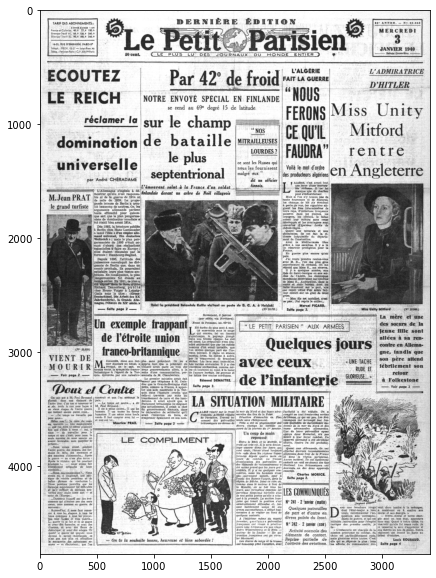

In [27]:
original = cv2.imread("data/full_set/bpt6k683902h_1.jpg", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(15, 10))
plt.imshow(original, cmap='gray')

In [4]:
# extracts a sub part of the image: returns a patch
def extract(img, i, j, w, h):
    return img[i:i+w, j:j+h]

# computes the fft of a patch; returns the magnitude spectrum
def compute_fft(patch):
    f = np.fft.fft2(patch)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift))
    return magnitude_spectrum

# creates mask to focus on the halftone components of the magnitude spectrum
def create_mask(m,n):
    mask = np.zeros((m,n))
    radius = (m+n)//40
    a = int((n/4 + n/3)/2)
    b = int((m/4 + m/3)/2)
    cv2.circle(mask, (a,b), radius, 1, thickness=-1)
    cv2.circle(mask, (a,m-b), radius, 1, thickness=-1)
    cv2.circle(mask, (n-a,b), radius, 1, thickness=-1)
    cv2.circle(mask, (n-a,m-b), radius, 1, thickness=-1)
    return mask

# classifies a patch as halftone or not
def classify(patch, mask, threshold):
    f = compute_fft(patch)
    filtered_f = f > np.quantile(f, threshold)
    masked_f = filtered_f * mask

    m,n = masked_f.shape
    tl = masked_f[:m//2, :n//2]
    tr = masked_f[:m//2, n//2:]
    bl = masked_f[m//2:, :n//2]
    br = masked_f[m//2:, n//2:]
    
    # if all four quadrants contain at least one non-zero value, then the patch is classified as halftone
    return (np.max(tl) > 0 and np.max(tr) > 0 and np.max(bl) > 0 and np.max(br) > 0)

In [28]:
PATCH_SIZE = 40                             # size of the patch
STEP = PATCH_SIZE                           # step between two patches
THRESHOLD = .96                             # threshold for the spectrum
MASK = create_mask(PATCH_SIZE, PATCH_SIZE)  # mask for the spectrum
MIN_SIZE = 10000                            # minimum size for a connected component to be kept

def segmentation(img):

    # create empty halftone map
    halftone_map = np.zeros(img.shape)

    # compute the halftone map by classifying each patch on the page
    for i in range(0, img.shape[0] - PATCH_SIZE, STEP):
        for j in range(0, img.shape[1] - PATCH_SIZE, STEP):
            patch = extract(img, i, j, PATCH_SIZE, PATCH_SIZE)
            cla = classify(patch, MASK, THRESHOLD)
            if cla:
                halftone_map[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += 1
    
    # plt.figure(figsize=(15, 10))
    # plt.imshow(halftone_map)
    # plt.show()

    # label the connected components in the halftone map
    halftone_map_bin = (halftone_map > 0).astype(np.uint8)
    _, labels = cv2.connectedComponents(halftone_map_bin)

    # plt.figure(figsize=(15, 10))
    # plt.imshow(halftone_map_bin)
    # plt.show()

    # remove small connected components
    sizes = np.bincount(labels.flatten())
    for i in range(1, len(sizes)):
        if sizes[i] < MIN_SIZE:
            labels[labels == i] = 0

    # compute the bounding boxes of the remaining connected components
    bounding_boxes = []
    for i in range(1, labels.max()+1):
        mask = (labels == i).astype(np.uint8)
        if(np.max(mask) > 0):
            bounding_boxes.append(cv2.boundingRect(mask))

    return halftone_map_bin, bounding_boxes

<ipython-input-4-c2bdbd249a28>:9: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = np.log(np.abs(fshift))


[(2560, 1520, 800, 1080), (920, 1640, 1200, 920), (40, 1760, 440, 1200)]


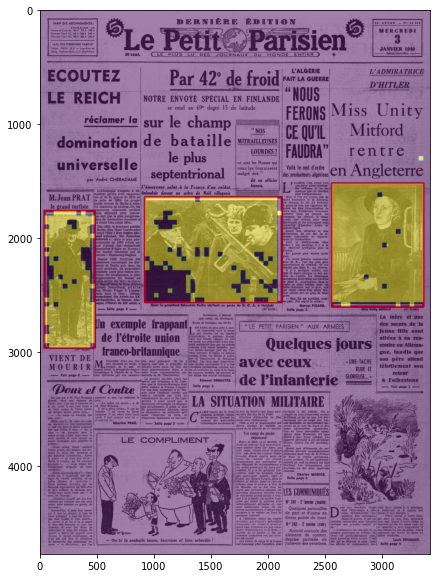

In [29]:
# displays the halftone map and the bouding boxes on the original image

img = original.copy()

halftone_map_bin, bounding_boxes = segmentation(img)
print(bounding_boxes)

image_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for x, y, w, h in bounding_boxes:
    cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (255, 0, 0), 20)

plt.figure(figsize=(15, 10))
plt.imshow(image_rgb, cmap='gray')
plt.imshow(halftone_map_bin, alpha=.5)
plt.show()

## Segmentation on test set

### Segmentation of the photos

In [39]:
FOLDER_INPUT = 'data/test_set'
FOLDER_EXTRACTION = 'output/test_set/local/extraction'
FOLDER_DRAFT = 'output/test_set/local/draft'
FILE_SEGMENTATION = 'output/test_set/local/segmentation.csv'
FILE_GROUNDTRUTH = 'data/test_set/bb_groundtruth_non_empty.csv'

In [ ]:
with open(FILE_SEGMENTATION, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes'])

    for filename in os.listdir(FOLDER_INPUT):
        if filename.endswith('.jpg'):
            image_path = os.path.join(FOLDER_INPUT, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            file_size = os.path.getsize(image_path)
            
            halftone_map_bin, bounding_boxes = segmentation(image)

            # image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # if there are no bounding boxes in the image, write an empty row
            if len(bounding_boxes) == 0:
                writer.writerow([filename, file_size, "{}", 0, "{}", "{}", "{}"])
            else:
                for region_id, (x, y, w, h) in enumerate(bounding_boxes):
                    region_shape_attributes = f'{{"name":"rect","x":{x},"y":{y},"width":{w},"height":{h}}}'
                    writer.writerow([filename, file_size, "{}", len(bounding_boxes), region_id, region_shape_attributes, "{}"])
                    # cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (255, 0, 0), 20)


            # plt.figure(figsize=(10, 15))
            # plt.imshow(image_rgb, cmap='gray')
            # plt.imshow(halftone_map_bin, alpha=.5)
            # plt.savefig(os.path.join(FOLDER_DRAFT, filename))
   
            print(filename, len(bounding_boxes))

### Evaluation of the segmentation

In [19]:
# intersection over union metric
def iou(bb1, bb2):

    if bb1 == "{}" and bb2 == "{}":
        return 1
    elif bb1 == "{}" or bb2 == "{}":
        return 0

    _, x1, y1, w1, h1 = json.loads(bb1).values()
    _, x2, y2, w2, h2 = json.loads(bb2).values()

    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = w1 * h1
    boxBArea = w2 * h2

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


# reads the groundtruth csv file
def read_csv(file):
    data = {}
    with open(file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes = row
            if filename not in data:
                data[filename] = []
            data[filename].append(region_shape_attributes)
    return data


# computes the IoU between two sets of bounding boxes
def compute_iou(bb1, bb2):
    iou_sum = 0
    non_zero = 0
    for i in range(len(bb1)):
        for j in range(len(bb2)):
            res = iou(bb1[i], bb2[j])
            if res > 0:
                non_zero += 1
            iou_sum += res
    if non_zero == 0:
        return 0
    return iou_sum / non_zero

bpt6k6841780_2.jpg 0.8030395551323405
bpt6k6841767_4.jpg 0.25255701148233656
bpt6k6841644_4.jpg 0.971347159471216
bpt6k6841610_1.jpg 0.7035706861218447
bpt6k6839697_1.jpg 0.9580848425551858
bpt6k6839663_4.jpg 0.9549048393943682
bpt6k6839451_4.jpg 0.8789846789446976
bpt6k6839451_1.jpg 0.9493722374606642
bpt6k6839150_1.jpg 0.9341617894728239
bpt6k684232n_2.jpg 0.9247193133725934
bpt6k684221x_1.jpg 0.558904590360681
bpt6k684202m_4.jpg 0.9409106936102949
bpt6k684189q_1.jpg 0.9134019295236919
bpt6k684184t_4.jpg 0.9686517788169525
bpt6k684171b_2.jpg 0.9560424802803205
bpt6k684165h_4.jpg 0.928647904826429
bpt6k684160m_4.jpg 0.6569688404841032
bpt6k684157x_2.jpg 0.9017093574039958
bpt6k684153d_4.jpg 0.8543968565580276
bpt6k684153d_1.jpg 0.9015095826934696
bpt6k684006h_3.jpg 0.8969764114920027
bpt6k683997h_1.jpg 0.9351364057872579
bpt6k683983n_5.jpg 0.9756920990243797
bpt6k683974p_1.jpg 0.9370163181808326
bpt6k683958h_1.jpg 0.9490757310932206
bpt6k683951v_1.jpg 0.9478387796076228
bpt6k683942w_1

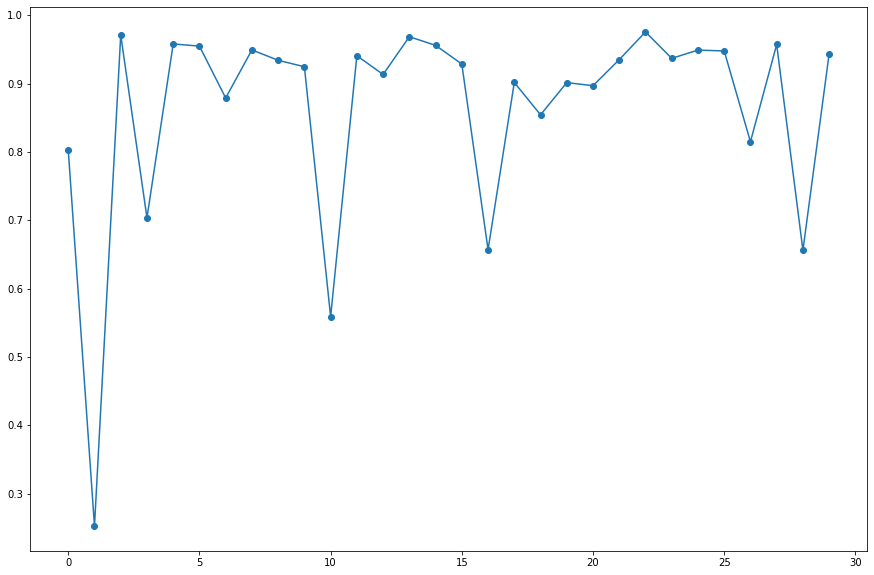

In [40]:
bb_groundtruth = read_csv(FILE_GROUNDTRUTH)
bb_segmentation = read_csv(FILE_SEGMENTATION)

iou_values = []
for filename in bb_groundtruth:
    iou_val = compute_iou(bb_groundtruth[filename], bb_segmentation[filename])
    print(filename, iou_val)
    iou_values.append(iou_val)

iou_avg = np.mean(iou_values)
iou_min = np.min(iou_values)
iou_max = np.max(iou_values)
iou_quantiles = np.percentile(iou_values, [25, 50, 75])

print("\nAverage IOU:", iou_avg)
print("Min IOU:", iou_min)
print("Max IOU:", iou_max)
print("25th, 50th, 75th Quantiles:", iou_quantiles)

plt.figure(figsize=(15, 10))
plt.plot(iou_values, '-o')
plt.show()

### Extraction of the photos

In [45]:
with open(FILE_SEGMENTATION, mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes = row
        if region_count == '0':
            continue
        _, x, y, w, h = json.loads(region_shape_attributes).values()
        image = cv2.imread(f'{FOLDER_INPUT}/{filename}', cv2.IMREAD_GRAYSCALE)
        photo = extract(image, y, x, h, w)
        cv2.imwrite(f'{FOLDER_EXTRACTION}/{filename[:-4]}_{x}_{y}_{w}_{h}.jpg', photo)

        print(filename, x, y, w, h)

bpt6k683926q_1.jpg 2560 1320 800 960
bpt6k683926q_1.jpg 80 1480 1200 680
bpt6k683926q_1.jpg 1720 1600 400 800
bpt6k6839697_1.jpg 2560 1400 840 840
bpt6k6839697_1.jpg 1320 1880 400 800
bpt6k6839697_1.jpg 80 2240 400 840
bpt6k6839697_1.jpg 960 3360 1200 840
bpt6k684171b_2.jpg 1320 160 800 800
bpt6k6841767_4.jpg 1320 560 840 1280
bpt6k684012b_4.jpg 1760 440 400 400
bpt6k683930s_3.jpg 1360 3240 1160 800
bpt6k684153d_4.jpg 880 1040 840 720
bpt6k684153d_4.jpg 2520 2320 440 480
bpt6k6839451_4.jpg 520 680 400 480
bpt6k6839451_4.jpg 2680 3640 320 440
bpt6k683951v_1.jpg 80 1400 400 760
bpt6k683951v_1.jpg 2960 1800 400 720
bpt6k683951v_1.jpg 1760 2400 1160 1000
bpt6k683951v_1.jpg 520 3880 1200 880
bpt6k684036j_4.jpg 3240 1000 120 200
bpt6k684036j_4.jpg 3000 2200 240 640
bpt6k684003c_4.jpg 2560 400 120 240
bpt6k684003c_4.jpg 2640 600 440 1240
bpt6k684003c_4.jpg 2280 680 320 520
bpt6k684003c_4.jpg 1920 880 280 120
bpt6k684003c_4.jpg 1840 1000 280 320
bpt6k684003c_4.jpg 1840 1160 680 920
bpt6k684202